In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from project_permed.atc_utils import get_atc_level_n
from project_permed.atc_dict import get_atc_codes, get_concept_name
from scipy.sparse import csr_matrix
import numpy as np

In [6]:
get_atc_codes(1124300)

('D11AX18', 'M01AB05', 'M02AA15', 'S01BC03')

In [7]:
get_concept_name(1124300)

'diclofenac'

In [8]:
get_atc_level_n(get_atc_codes(1367571), 2)

{'B01', 'C05', 'S01'}

# filter for switch patterns

In [2]:
switch_people = pd.read_csv("output_switch/switch_people_freq.tsv", sep="\t")

In [23]:
switch_people["people_count"].describe()

count    442781.000000
mean         48.076828
std         324.298923
min           1.000000
25%           1.000000
50%           4.000000
75%          15.000000
max       38923.000000
Name: people_count, dtype: float64

In [26]:
print(len(switch_people[switch_people["people_count"] >= 10]))
print(len(switch_people[switch_people["people_count"] >= 20]))
print(
    len(switch_people[switch_people["people_count"] >= 30])
)  # 30 might be a fair threshold
print(len(switch_people[switch_people["people_count"] >= 50]))
print(len(switch_people[switch_people["people_count"] >= 100]))

141592
96810
76152
54905
33618


In [3]:
switch_people = switch_people[switch_people["people_count"] >= 30]

In [13]:
len(switch_people)
# 76152 switch patterns after filtering

76152

In [5]:
switch_df = pd.read_csv(
    "../../dataset/drug_switches_closest.tsv", sep="\t", low_memory=False
)

In [6]:
# Filter switch_df to only include switches that have >= 30 people
switch_df = switch_df.merge(
    switch_people[["A_drug_concept_id", "B_drug_concept_id"]],
    on=["A_drug_concept_id", "B_drug_concept_id"],
    how="inner",
)

In [8]:
len(switch_df)
# 34520679 switches after filtering

34520679

# switch vs switch

dataset structure:
each row: a drug switch from drug A to drug B. 
columns include:
- eid: the id of the person
- A_drug_era_id: the id of the drug A (source)
- B_drug_era_id: the id of the drug B (destination)
- switch_interval: the number of days between the two drug eras

In [28]:
# Create a unique identifier for each switch pattern using hash
def hash_switch(a, b):
    return hash((a, b))


# Get unique patient-switch combinations
unique_switches = switch_df.drop_duplicates(
    subset=["eid", "A_drug_concept_id", "B_drug_concept_id"]
)

# Create mask for N-category switches
mask = [
    "N" in get_atc_level_n(get_atc_codes(a), 1)
    and "N" in get_atc_level_n(get_atc_codes(b), 1)
    for a, b in zip(
        unique_switches["A_drug_concept_id"], unique_switches["B_drug_concept_id"]
    )
]

# Create switch patterns and store only N-category switches
switch_patterns = [
    hash((a, b))  # Using hash directly as suggested
    for a, b, is_n in zip(
        unique_switches["A_drug_concept_id"], unique_switches["B_drug_concept_id"], mask
    )
    if is_n  # Only include if it's an N-category switch
]

# Store the original pairs for decoding (only N-category switches)
switch_dict = {
    hash((a, b)): (a, b)
    for a, b, is_n in zip(
        unique_switches["A_drug_concept_id"], unique_switches["B_drug_concept_id"], mask
    )
    if is_n
}

# Create a Series with the same index as the unique switches
pattern_series = pd.Series(index=unique_switches.index, dtype=object)
pattern_series[mask] = [
    hash((a, b))
    for a, b in zip(
        unique_switches.loc[mask, "A_drug_concept_id"],
        unique_switches.loc[mask, "B_drug_concept_id"],
    )
]

# Create the crosstab
switch_matrix = pd.crosstab(unique_switches["eid"], pattern_series)

In [29]:
len(unique_switches)

19351213

In [53]:
len(switch_patterns)

661388

In [54]:
len(switch_dict)

1875

In [286]:
switch_matrix.shape

(112979, 1875)

In [216]:
# verifying whether the switch_matrix is binary
print(switch_matrix.values.max())
print(switch_matrix.values.min())

1
0


In [30]:
# Convert switch_matrix to sparse matrix for better performance
sparse_matrix = csr_matrix(switch_matrix)


# Calculate PMI using vectorized operations
def calculate_pmi_fast(matrix):
    # Get probabilities using matrix operations
    n_samples = matrix.shape[0]

    # P(x) for all switches - column-wise means
    p_x = np.array(matrix.mean(axis=0)).flatten()

    # P(x,y) for all pairs - normalized dot product
    p_xy = (matrix.T @ matrix) / n_samples

    # Calculate PMI matrix
    epsilon = 1e-30
    # Outer product of p_x with itself gives us p_x * p_y for all pairs
    pmi = np.log2((p_xy.toarray() + epsilon) / (np.outer(p_x, p_x) + epsilon))

    return pmi


# Calculate PMI for all pairs at once
pmi_matrix = calculate_pmi_fast(sparse_matrix)

# Convert to dictionary of pairs with their PMI scores
switches = switch_matrix.columns
pmi_scores = {
    (switches[i], switches[j]): pmi_matrix[i, j]
    for i in range(len(switches))
    for j in range(i + 1, len(switches))
}

In [218]:
len(pmi_scores)

1756875

In [219]:
# see the statistics of the pmi scores
print(pd.Series(pmi_scores).describe())

count    1.756875e+06
mean    -4.935779e+01
std      3.909068e+01
min     -8.638223e+01
25%     -7.905188e+01
50%     -7.736374e+01
75%      1.508478e+00
max      1.187880e+01
dtype: float64


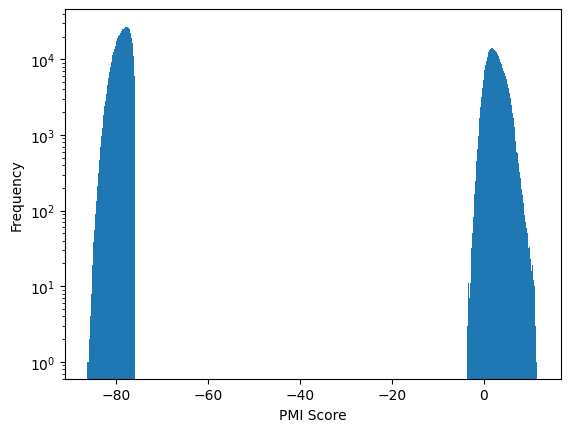

In [281]:
# see the distribution of the pmi scores
plt.hist(pmi_scores.values(), bins=1000)
plt.yscale("log")
plt.xlabel("PMI Score")
plt.ylabel("Frequency")
plt.show()

In [32]:
# Create a list to store the results
results = []
for (switch1, switch2), pmi in pmi_scores.items():
    # Get original drug pairs
    drug_a1, drug_b1 = switch_dict[switch1]  # type: ignore
    drug_a2, drug_b2 = switch_dict[switch2]  # type: ignore

    # Get names and ATC codes
    name_a1 = get_concept_name(drug_a1)
    name_b1 = get_concept_name(drug_b1)
    name_a2 = get_concept_name(drug_a2)
    name_b2 = get_concept_name(drug_b2)

    atc_a1 = ",".join(get_atc_codes(drug_a1))
    atc_b1 = ",".join(get_atc_codes(drug_b1))
    atc_a2 = ",".join(get_atc_codes(drug_a2))
    atc_b2 = ",".join(get_atc_codes(drug_b2))

    results.append(
        {
            "switch1_drug_a_name": name_a1,
            "switch1_drug_a_atc": atc_a1,
            "switch1_drug_b_name": name_b1,
            "switch1_drug_b_atc": atc_b1,
            "switch2_drug_a_name": name_a2,
            "switch2_drug_a_atc": atc_a2,
            "switch2_drug_b_name": name_b2,
            "switch2_drug_b_atc": atc_b2,
            "pmi_score": pmi,
        }
    )

# Convert to DataFrame and save
results_df = pd.DataFrame(results)
results_df.sort_values("pmi_score", ascending=False, inplace=True)
results_df.to_csv("../../dataset/drug_switch_pmi.tsv", sep="\t", index=False)

In [222]:
results_df

,switch1_drug_a_name,switch1_drug_a_atc,switch1_drug_b_name,switch1_drug_b_atc,switch2_drug_a_name,switch2_drug_a_atc,switch2_drug_b_name,switch2_drug_b_atc,pmi_score
748966,nortriptyline,N06AA10,fluphenazine,N05AB02,fluphenazine,N05AB02,nortriptyline,N06AA10,11.878805
1668226,propoxyphene,N02AC04,salicylamide,N02BA05,propoxyphene,N02AC04,benzocaine,"C05AD03,D04AB04,N01BA05,R02AD01",11.656412
281711,caffeine,"D11AX26,N06BC01",pizotyline,N02CX01,ergotamine,N02CA02,pizotyline,N02CX01,11.615770
67287,benzocaine,"C05AD03,D04AB04,N01BA05,R02AD01",propoxyphene,N02AC04,salicylamide,N02BA05,propoxyphene,N02AC04,11.615770
297414,amitriptyline,N06AA09,caffeine,"D11AX26,N06BC01",amitriptyline,N06AA09,ergotamine,N02CA02,11.615770
...,...,...,...,...,...,...,...,...,...
1530629,acetaminophen,N02BE01,zolmitriptan,N02CC03,aspirin,"A01AD05,B01AC06,N02BA01",lidocaine,"C01BB01,C05AD01,D04AB01,N01BB02,R02AD02,S01HA0...",-85.869380
108910,aspirin,"A01AD05,B01AC06,N02BA01",acetaminophen,N02BE01,citalopram,N06AB04,olanzapine,N05AH03,-86.043770
209763,citalopram,N06AB04,olanzapine,N05AH03,acetaminophen,N02BE01,aspirin,"A01AD05,B01AC06,N02BA01",-86.154696
1531414,aspirin,"A01AD05,B01AC06,N02BA01",aspirin,"A01AD05,B01AC06,N02BA01",paroxetine,N06AB05,escitalopram,N06AB10,-86.220809


In [33]:
results_df_nonzero = results_df[results_df["pmi_score"] > -10]

In [37]:
results_df_nonzero.to_csv(
    "../../dataset/drug_switch_pair_pmi_nonzero.tsv", sep="\t", index=False
)

count    635087.000000
mean          2.548083
std           1.807296
min          -4.132932
25%           1.239288
50%           2.367151
75%           3.717124
max          11.878805
Name: pmi_score, dtype: float64


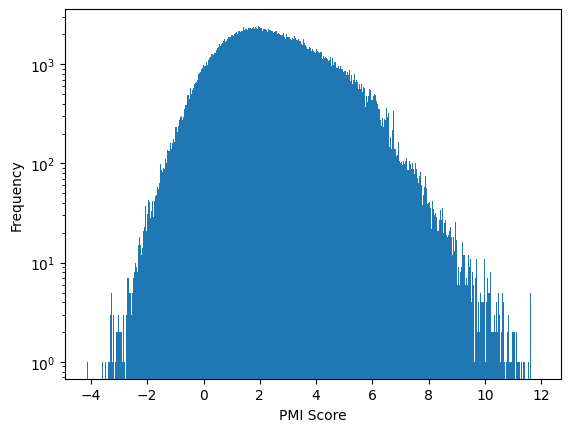

In [230]:
print(results_df_nonzero["pmi_score"].describe())
plt.hist(results_df_nonzero["pmi_score"].values, bins=1000)
plt.yscale("log")
plt.xlabel("PMI Score")
plt.ylabel("Frequency")
plt.show()

In [50]:
# switch pairs where (switch1_drug_a_name, switch1_drug_b_name, switch2_drug_a_name, switch2_drug_b_name) are different to each other
results_df_nonzero_diff = results_df_nonzero[
    (
        results_df_nonzero["switch1_drug_a_name"]
        != results_df_nonzero["switch2_drug_b_name"]
    )
    & (
        results_df_nonzero["switch1_drug_b_name"]
        != results_df_nonzero["switch2_drug_a_name"]
    )
    & (
        results_df_nonzero["switch1_drug_a_name"]
        != results_df_nonzero["switch2_drug_a_name"]
    )
    & (
        results_df_nonzero["switch1_drug_b_name"]
        != results_df_nonzero["switch2_drug_b_name"]
    )
]
results_df_nonzero_diff.to_csv(
    "../../dataset/drug_switch_pair_pmi_nonzero_diff.tsv", sep="\t", index=False
)

In [38]:
def analyze_switch_pair(switch1_source, switch1_dest, switch2_source, switch2_dest):
    # Find the hash values that correspond to these drug switches
    switch1_hash = None
    switch2_hash = None

    for hash_val, (drug_a, drug_b) in switch_dict.items():
        if (
            get_concept_name(drug_a) == switch1_source
            and get_concept_name(drug_b) == switch1_dest
        ):
            switch1_hash = hash_val
        elif (
            get_concept_name(drug_a) == switch2_source
            and get_concept_name(drug_b) == switch2_dest
        ):
            switch2_hash = hash_val

    if switch1_hash is None or switch2_hash is None:
        print("One or both switches not found in the dataset")
        return

    # Calculate probabilities
    n_samples = switch_matrix.shape[0]
    p_x = switch_matrix[switch1_hash].sum() / n_samples
    p_y = switch_matrix[switch2_hash].sum() / n_samples
    p_xy = (switch_matrix[switch1_hash] & switch_matrix[switch2_hash]).sum() / n_samples

    # Calculate PMI
    epsilon = 1e-30
    pmi = np.log2((p_xy + epsilon) / (p_x * p_y + epsilon))

    print(f"Switch 1: {switch1_source} → {switch1_dest}")
    print(f"Switch 2: {switch2_source} → {switch2_dest}")
    print(f"PMI score: {pmi:.3f}")
    print(f"P(x): {p_x:.6f}")
    print(f"P(y): {p_y:.6f}")
    print(f"P(x,y): {p_xy:.6f}")

In [52]:
analyze_switch_pair("caffeine", "pizotyline", "amitriptyline", "ergotamine")

Switch 1: caffeine → pizotyline
Switch 2: amitriptyline → ergotamine
PMI score: 9.831
P(x): 0.000319
P(y): 0.000274
P(x,y): 0.000080


## clustering

In [54]:
import networkx as nx  # type: ignore
from community import community_louvain  # type: ignore
from collections import defaultdict

In [55]:
def create_switch_graph(pmi_scores, switch_dict, min_pmi=2.0):
    G = nx.Graph()

    # Add edges between switches with significant PMI
    for (switch1, switch2), pmi in pmi_scores.items():
        if pmi > min_pmi:
            # Add nodes with their drug information
            if switch1 not in G:
                G.add_node(switch1, drugs=switch_dict[switch1])
            if switch2 not in G:
                G.add_node(switch2, drugs=switch_dict[switch2])

            # Add edge with PMI score as weight
            G.add_edge(switch1, switch2, weight=pmi)  # Using PMI as edge weight

    return G

In [56]:
def find_switch_clusters(G):
    communities = community_louvain.best_partition(G)

    # Group switches by community
    community_groups = defaultdict(list)
    for switch_hash, community_id in communities.items():
        drug_a, drug_b = G.nodes[switch_hash]["drugs"]
        community_groups[community_id].append(
            {
                "source_drug": get_concept_name(drug_a),
                "dest_drug": get_concept_name(drug_b),
                "source_id": drug_a,
                "dest_id": drug_b,
                "switch_hash": switch_hash,
            }
        )

    # Calculate cluster information
    cluster_info = []
    for community_id, switches in community_groups.items():
        switch_hashes = [s["switch_hash"] for s in switches]
        pmis = []
        missing_pairs = []  # Track pairs without edges
        total_pairs = 0

        for i, n1 in enumerate(switch_hashes):
            for n2 in switch_hashes[i + 1 :]:
                total_pairs += 1
                if G.has_edge(n1, n2):
                    pmis.append(G[n1][n2]["weight"])
                else:
                    # Get drug names for pairs without edges
                    drug_a1, drug_b1 = G.nodes[n1]["drugs"]
                    drug_a2, drug_b2 = G.nodes[n2]["drugs"]
                    missing_pairs.append(
                        (
                            f"{get_concept_name(drug_a1)} → {get_concept_name(drug_b1)}",
                            f"{get_concept_name(drug_a2)} → {get_concept_name(drug_b2)}",
                        )
                    )

        avg_pmi = sum(pmis) / len(pmis) if pmis else 0
        coverage = len(pmis) / total_pairs if total_pairs > 0 else 0

        cluster_info.append(
            {
                "cluster_id": community_id,
                "size": len(switches),
                "avg_pmi": avg_pmi,
                "pmi_coverage": coverage,
                "switches": switches,
                "missing_pairs": missing_pairs,
            }
        )

    cluster_info.sort(key=lambda x: (-x["size"], -x["avg_pmi"]))
    return cluster_info


# Create the graph and find clusters
G = create_switch_graph(pmi_scores, switch_dict, min_pmi=4.0)
clusters = find_switch_clusters(G)

# Print cluster statistics
print(f"Total number of clusters: {len(clusters)}")
sizes = [c["size"] for c in clusters]
print(
    f"Cluster sizes: min={min(sizes)}, max={max(sizes)}, mean={sum(sizes)/len(sizes):.1f}"
)
print(
    f"Number of clusters with size > 1: {len([c for c in clusters if c['size'] > 1])}"
)
print(
    f"Average PMI Coverage (weighted by cluster size): {sum([c['pmi_coverage'] * c['size'] for c in clusters]) / sum([c['size'] for c in clusters]):.1%}"
)
print(
    f"Average PMI value (weighted by cluster size): {sum([c['avg_pmi'] * c['size'] for c in clusters]) / sum([c['size'] for c in clusters]):.1f}"
)

# Print detailed information for first 5 clusters
for cluster in clusters[:5]:
    print(f"\nCluster {cluster['cluster_id']}:")
    print(f"Size: {cluster['size']}")
    print(f"Average PMI: {cluster['avg_pmi']:.3f}")
    print(f"PMI Coverage: {cluster['pmi_coverage']:.1%}")

    print("\nSome switches in cluster:")
    for switch in cluster["switches"][:3]:
        print(f"  {switch['source_drug']} → {switch['dest_drug']}")

    print("\nExample pairs without direct edges:")
    if cluster["missing_pairs"]:
        for pair in cluster["missing_pairs"][:3]:
            print(f"  {pair[0]} and {pair[1]}")
    else:
        print("  No missing pairs (all switches are directly connected)")
    print("-" * 50)

Total number of clusters: 9
Cluster sizes: min=2, max=493, mean=206.7
Number of clusters with size > 1: 9
Average PMI Coverage (weighted by cluster size): 23.4%
Average PMI value (weighted by cluster size): 5.4

Cluster 7:
Size: 493
Average PMI: 5.178
PMI Coverage: 9.9%

Some switches in cluster:
  propoxyphene → acetaminophen
  benzocaine → propoxyphene
  propoxyphene → nicotine

Example pairs without direct edges:
  propoxyphene → acetaminophen and fluoxetine → nicotine
  propoxyphene → acetaminophen and dothiepin → pregabalin
  propoxyphene → acetaminophen and tramadol → nitrazepam
--------------------------------------------------

Cluster 5:
Size: 486
Average PMI: 5.423
PMI Coverage: 19.6%

Some switches in cluster:
  gabapentin → venlafaxine
  zopiclone → nitrazepam
  tramadol → escitalopram

Example pairs without direct edges:
  gabapentin → venlafaxine and tramadol → escitalopram
  gabapentin → venlafaxine and amitriptyline → mirtazapine
  gabapentin → venlafaxine and prochlorp

In [57]:
# Create a list to store all switch information with their cluster assignments
cluster_results = []
for cluster in clusters:
    for switch in cluster["switches"]:
        cluster_results.append(
            {
                "cluster_id": cluster["cluster_id"],
                "cluster_size": cluster["size"],
                "cluster_avg_pmi": cluster["avg_pmi"],
                "cluster_pmi_coverage": cluster["pmi_coverage"],
                "source_id": switch["source_id"],
                "source_name": switch["source_drug"],
                "source_atc": get_atc_codes(switch["source_id"]),
                "dest_id": switch["dest_id"],
                "dest_name": switch["dest_drug"],
                "dest_atc": get_atc_codes(switch["dest_id"]),
            }
        )

# Convert to DataFrame and save
results_df = pd.DataFrame(cluster_results)
results_df.to_csv("output_switch/drug_switch_pmi_clusters.tsv", sep="\t", index=False)

Starting visualization...
Calculating layout...
Drawing nodes...
Drawing edges...


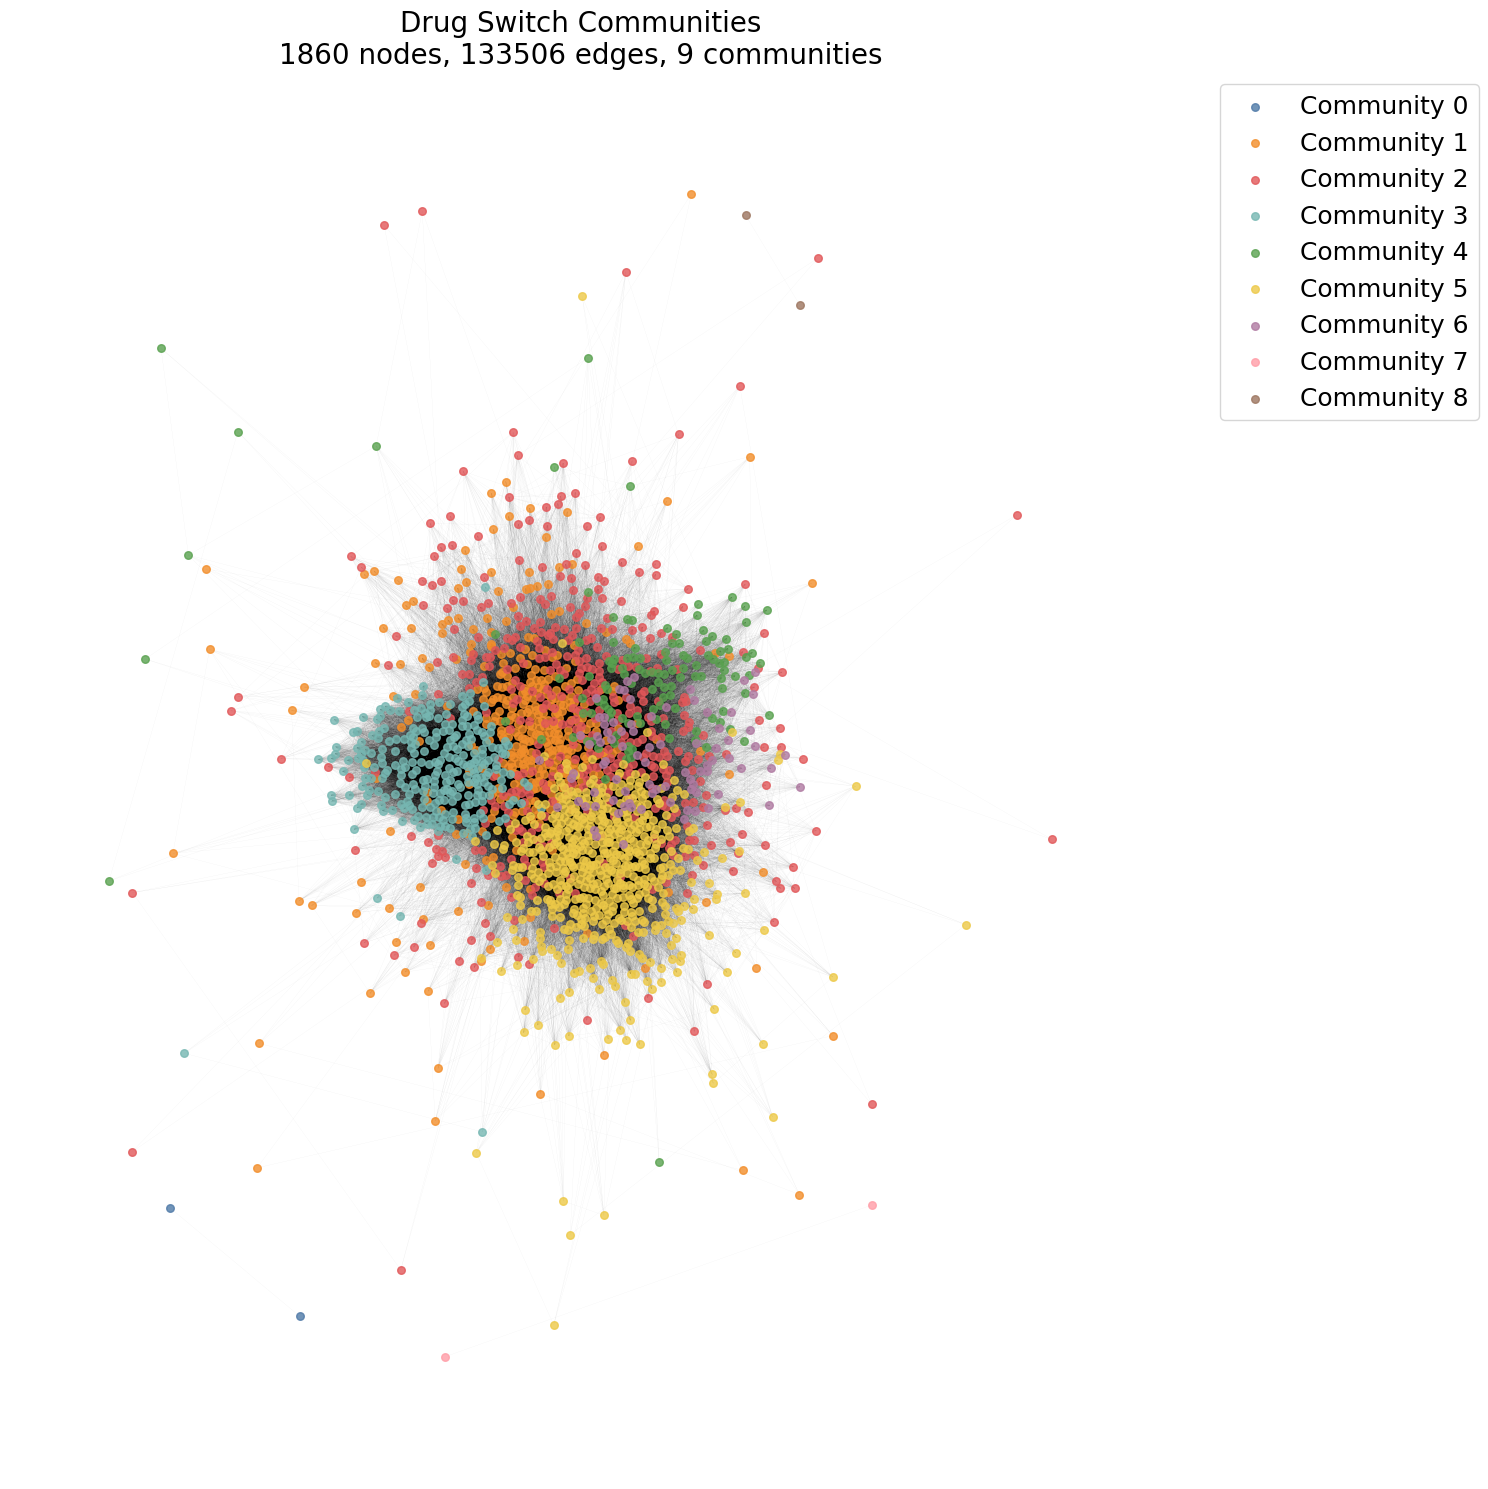

In [67]:
def visualize_clusters(G, communities, max_nodes=500):
    # Set up the plot
    plt.figure(figsize=(15, 15))

    # Define a professional color palette (using Tableau 20 colors)
    colors = [
        "#4e79a7",
        "#f28e2b",
        "#e15759",
        "#76b7b2",
        "#59a14f",
        "#edc948",
        "#af7aa1",
        "#ff9da7",
        "#9c755f",
        "#bab0ab",
        "#a0cbe8",
        "#ffbe7d",
        "#ff9d9a",
        "#86bc9b",
        "#d4a6c8",
        "#f1ce63",
        "#8cd17d",
        "#b6992d",
        "#499894",
        "#dc755b",
    ]

    # Use spring layout for node positions
    print("Calculating layout...")
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes, colored by community
    print("Drawing nodes...")
    for i, community_id in enumerate(set(communities.values())):
        nodes = [n for n, comm in communities.items() if comm == community_id]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_size=30,
            node_color=colors[i % len(colors)],  # Cycle through colors
            alpha=0.8,
            label=f"Community {community_id}",
        )

    # Draw edges
    print("Drawing edges...")
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.1,
        width=0.1,
    )

    plt.title(
        f"Drug Switch Communities\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges, {len(set(communities.values()))} communities",
        fontsize=20,
    )
    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=18
    )  # Increased legend font size
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Create the visualization
print("Starting visualization...")
communities = community_louvain.best_partition(G)
visualize_clusters(G, communities)

#  source vs destination

based on drug switch times.

example:

- person 1: A -> B
- person 1: A -> B
- person 1: C -> D
- person 1: A -> C
- person 2: B -> D
- person 2: A -> B
- person 3: E -> B
- person 3: A -> F

P (A being the source) = 5/8

P (B being the destination) = 4/8

P (A being the source and B being the destination) = 3/8

PMI = log2(P(A,B) / P(A) * P(B))

In [14]:
# Create unique identifiers for each drug
unique_source_drugs = switch_df["A_drug_concept_id"].unique()
unique_dest_drugs = switch_df["B_drug_concept_id"].unique()
source_drug_to_idx = {drug: idx for idx, drug in enumerate(unique_source_drugs)}
dest_drug_to_idx = {drug: idx for idx, drug in enumerate(unique_dest_drugs)}

# Create sparse matrix of transitions
n_sources = len(unique_source_drugs)
n_dests = len(unique_dest_drugs)
transitions = csr_matrix(
    (
        np.ones(len(switch_df)),
        (
            [source_drug_to_idx[d] for d in switch_df["A_drug_concept_id"]],
            [dest_drug_to_idx[d] for d in switch_df["B_drug_concept_id"]],
        ),
    ),
    shape=(n_sources, n_dests),
)

# Calculate probabilities
total_switches = transitions.sum()
p_source = np.array(transitions.sum(axis=1)).flatten() / total_switches  # P(source)
p_dest = np.array(transitions.sum(axis=0)).flatten() / total_switches  # P(dest)
p_joint = transitions.toarray() / total_switches  # P(source,dest)

# Calculate PMI
epsilon = 1e-30  # to avoid log(0)
pmi = np.log2((p_joint + epsilon) / (np.outer(p_source, p_dest) + epsilon))

# Convert to dictionary with drug pairs
pmi_scores = {}
for i, source_drug in enumerate(unique_source_drugs):
    for j, dest_drug in enumerate(unique_dest_drugs):
        pmi_scores[(source_drug, dest_drug)] = pmi[i, j]

In [185]:
print(n_sources)
print(n_dests)

777
779


In [196]:
transitions

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 76152 stored elements and shape (777, 779)>

count    605283.000000
mean        -64.000080
std          24.673839
min         -86.213624
25%         -75.941095
50%         -72.725236
75%         -68.490634
max          19.286070
dtype: float64


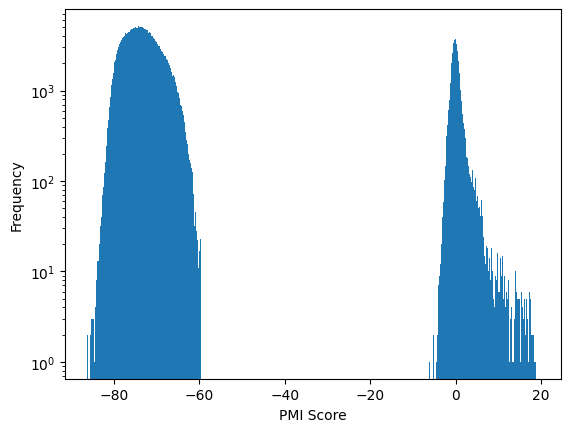

In [186]:
# see the statistics of the pmi scores
print(pd.Series(pmi_scores).describe())

# see the distribution of the pmi scores
plt.hist(pmi_scores.values(), bins=1000)
plt.yscale("log")
plt.xlabel("PMI Score")
plt.ylabel("Frequency")
plt.show()

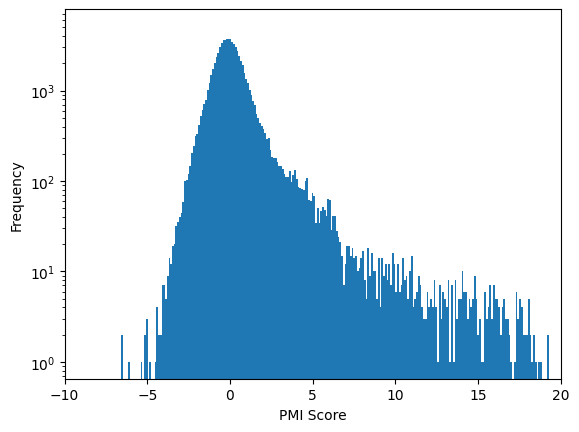

In [214]:
plt.hist(pmi_scores.values(), bins=1000)
plt.yscale("log")
plt.xlabel("PMI Score")
plt.ylabel("Frequency")
plt.xlim(-10, 20)
plt.show()

In [15]:
# Store results in DataFrame with drug names and sort by PMI score
results = []
for (source_drug, dest_drug), score in pmi_scores.items():
    results.append(
        {
            "source_drug_id": source_drug,
            "source_drug_name": get_concept_name(source_drug),
            "source_drug_atc": ",".join(get_atc_codes(source_drug)),
            "dest_drug_id": dest_drug,
            "dest_drug_name": get_concept_name(dest_drug),
            "dest_drug_atc": ",".join(get_atc_codes(dest_drug)),
            "pmi_score": score,
        }
    )

results_df = pd.DataFrame(results)
results_df.sort_values("pmi_score", ascending=False, inplace=True)
# results_df.to_csv(
#     "../../dataset/drug_switch_pmi_sourcedest_times.tsv", sep="\t", index=False
# )

In [19]:
# exclude self-switch
results_df_diff_drug = results_df[
    results_df["source_drug_id"] != results_df["dest_drug_id"]
]

results_df_diff_drug.to_csv(
    "../../dataset/drug_switch_pmi_sourcedest_times_diff_drug.tsv",
    sep="\t",
    index=False,
)

count    604515.000000
mean        -64.088962
std          24.555135
min         -86.213624
25%         -75.945520
50%         -72.734072
75%         -68.512271
max          16.173995
Name: pmi_score, dtype: float64


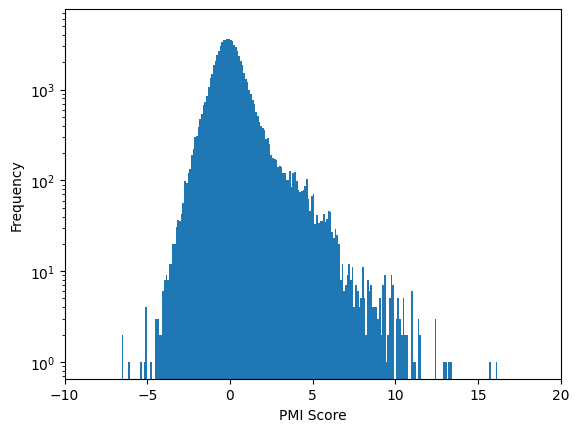

In [215]:
print(results_df_diff_drug["pmi_score"].describe())

plt.hist(results_df_diff_drug["pmi_score"].values, bins=1000)
plt.yscale("log")
plt.xlabel("PMI Score")
plt.ylabel("Frequency")
plt.xlim(-10, 20)
plt.show()

In [16]:
results_df_nonzero = results_df[results_df["pmi_score"] > -10]
results_df_nonzero.to_csv(
    "../../dataset/drug_switch_pmi_sourcedest_times_nonzero.tsv",
    sep="\t",
    index=False,
)

In [18]:
results_df_nonzero["pmi_score"].describe()

count    76152.000000
mean         0.225454
std          1.690515
min         -6.514141
25%         -0.594804
50%         -0.029662
75%          0.619119
max         19.286070
Name: pmi_score, dtype: float64

In [27]:
results_df_N06 = results_df[
    results_df.apply(
        lambda row: (
            "N06" in get_atc_level_n(get_atc_codes(row["source_drug_id"]), 2)
            and "N06" in get_atc_level_n(get_atc_codes(row["dest_drug_id"]), 2)
        ),
        axis=1,
    )
]

results_df_N06 = results_df_N06[results_df_N06["pmi_score"] > -10]

results_df_N06_diff = results_df_N06[
    results_df_N06["source_drug_id"] != results_df_N06["dest_drug_id"]
]
results_df_N06_diff.to_csv(
    "../../dataset/drug_switch_pmi_sourcedest_times_N06_diff.tsv",
    sep="\t",
    index=False,
)

In [20]:
def analyze_sourcedest_pair(source_drug_id, dest_drug_id):
    # Get drug names
    source_name = get_concept_name(source_drug_id)
    dest_name = get_concept_name(dest_drug_id)

    # Get probabilities from the transitions matrix
    total_switches = transitions.sum()

    # Calculate P(source) and P(dest)
    p_x = transitions[source_drug_to_idx[source_drug_id]].sum() / total_switches
    p_y = transitions[:, dest_drug_to_idx[dest_drug_id]].sum() / total_switches

    # Calculate P(source,dest)
    p_xy = (
        transitions[source_drug_to_idx[source_drug_id], dest_drug_to_idx[dest_drug_id]]
        / total_switches
    )

    # Calculate PMI
    epsilon = 1e-30
    pmi = np.log2((p_xy + epsilon) / (p_x * p_y + epsilon))

    print(f"Switch: {source_name} → {dest_name}")
    print(f"PMI score: {pmi:.3f}")
    print(f"P(x): {p_x:.7f}")
    print(f"P(y): {p_y:.7f}")
    print(f"P(x,y): {p_xy:.7f}")
    print(transitions[source_drug_to_idx[source_drug_id]].sum())
    print(transitions[:, dest_drug_to_idx[dest_drug_id]].sum())
    print(
        transitions[source_drug_to_idx[source_drug_id], dest_drug_to_idx[dest_drug_id]]
    )

In [21]:
analyze_sourcedest_pair(791967, 766814)

Switch: lorazepam → quetiapine
PMI score: 5.717
P(x): 0.0001577
P(y): 0.0001537
P(x,y): 0.0000013
5445.0
5305.0
44.0
